# Load the libraries

In [126]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import max_norm
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Define some functions

In [278]:
# create a mapping mechanism for the file sequence in the test_generator and test file names
def create_generator_test_matched(test_generator):
    # create a dataframe generator_order with the file sequence from the test_generator
    generator_order = pd.DataFrame(test_generator.filenames)
    generator_order.columns = ['filename']
    generator_order['filename'] = generator_order.filename.apply(lambda x:x.split('/')[1])
    generator_order['index'] = generator_order.index

    # create a dataframe test_order with the file sequence in the test files
    test_order = pd.read_csv('animal_dataset_intermediate/Testing_set_animals.csv')
    test_order = test_order.drop(columns = ['target'])
    test_order['index'] = test_order.index
    
    #combine the index
    generator_test_matched = test_order.merge(generator_order,
                                                   on="filename",how="left",suffixes = ['_test','_generator'])
    return generator_test_matched
    
# show one batch of 32 images with their labels
# imputs images, labels_from_generator_model can be directly obtained from generator
# images, labels_from_generator_model = train_generator.next()
def show_images(images, labels_from_generator_model):
    labels_scaler = np.argmax(labels_from_generator_model, axis=1)
    num_rows, num_cols = 4, 8
    f, ax = plt.subplots(num_rows, num_cols, figsize=(20,10),
                        gridspec_kw={'wspace':0.15, 'hspace':0.25},
                        squeeze=True)
    for r in range(num_rows):
        for c in range(num_cols):
            image_index = r*8 + c
            ax[r,c].axis("off")
            ax[r,c].imshow(images[image_index])
            ax[r,c].set_title(categories[labels_scaler[image_index].item()])
    plt.show()
    plt.close
    
    
#input prediction from the model
#output the first batch test images with predicted labels
#not sure how to get the exact batch from the generator, had to rerun the test_generator and use next()
def prediction_showcase(prediction):
    test_generator = test_datagen.flow_from_directory("animal_dataset_intermediate/test/",
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                  shuffle = False,
                                                    target_size = (100, 100))
    x,y = test_generator.next()
    show_images(x,prediction[0:32])

# take the prediction from the model, convert to scaler, then labels, sort, write to csv
def prediction_to_csv(prediction, generator_test_matched, categories, filename):
    prediction_scaler = np.argmax(prediction, axis=1)
    prediction_scaler_sorted = prediction_scaler[generator_test_matched.index_generator]
    prediction_labels = [categories[i] for i in prediction_scaler_sorted]
    res = pd.DataFrame(prediction_labels)
    res.columns = ["prediction"]
    res.to_csv('results/' + filename + '.txt', index=False)

# TASK 1: Loading Data 
Load the data and save it in appropriate variables. Display an image and its corresponding label. 
# TASK 2: Pre-processing
Apply the required pre-processing steps on the image data. These may include scaling, converting to grayscale or anything else. Justify your decision about performing those particular pre-processing steps. 



In [201]:
# Used ImageDataGenerator to load the images and do preprocessing. 
# The structure of the dataset fits how ImageDataGenerator works, 
# and it can do data preprocess and augmentation easily.
train_datagen = ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory("animal_dataset_intermediate/train/",
                                                    batch_size = 32,
                                                    subset="training",
                                                    class_mode = 'categorical', 
                                                    target_size = (100, 100))

test_generator = test_datagen.flow_from_directory("animal_dataset_intermediate/test/",
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                  shuffle = False,
                                                    target_size = (100, 100))

val_generator = val_datagen.flow_from_directory("animal_dataset_intermediate/train/",
                                                subset = "validation",
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (100, 100))

Found 6558 images belonging to 5 classes.
Found 910 images belonging to 1 classes.
Found 1638 images belonging to 5 classes.


In [13]:
# define the category names for each class
categories = {
0: 'elefante',
1: 'farfalla',
2: 'mucca',
3: 'pecora',
4: 'scoiattolo'
}

In [258]:
generator_test_matched = create_generator_test_matched(test_generator)
generator_test_matched.head()

,filename,index_test,index_generator
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,0,372
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,1,373
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,2,374
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,3,375
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,4,376


In [ ]:
images,labels = train_generator.next()
show_images(images,labels)

# TASK 3: Building a Multi-Layer Perceptron
Create a multi-layer perceptron, deciding on the number of layers, neurons and activation functions that should be provided. Print a summary and architecture of the model. Explain the architecture.

# Model 1, MLP, with default settings and adam as the optimizer
# reaching accuracy of 40%


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               100663808 
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_36 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 505       
Total params: 100,821,341
Trainable params: 100,821,341
Non-trainable params: 0
_________________________________________________________________


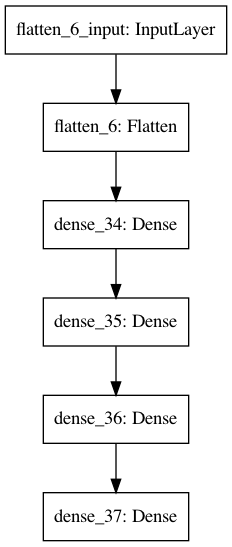

In [55]:
#simple MLP with image size [256x256]. accuracy 40%
model1 = Sequential([Flatten(input_shape=(256,256,3)),
                    Dense(512, input_shape=(196608,), activation='relu'),
                    Dense(256, input_shape=(512,), activation='relu'),
                    Dense(100, input_shape=(256,), activation='relu'),                     
                    Dense(5, activation='softmax')])
model1.summary()
plot_model(model1, to_file='doc/img/model1.png')

In [75]:
# compile the model with adam default settings
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=path,histogram_freq=1)

In [57]:
history = model1.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 20,
                     verbose = 2)

Epoch 1/20
205/205 - 389s - loss: 17.8874 - accuracy: 0.2423 - val_loss: 2.5455 - val_accuracy: 0.2668
Epoch 2/20
205/205 - 371s - loss: 2.3416 - accuracy: 0.2876 - val_loss: 1.9913 - val_accuracy: 0.2802
Epoch 3/20
205/205 - 383s - loss: 1.7544 - accuracy: 0.3094 - val_loss: 1.5395 - val_accuracy: 0.3327
Epoch 4/20
205/205 - 383s - loss: 1.6438 - accuracy: 0.3207 - val_loss: 1.5225 - val_accuracy: 0.3706
Epoch 5/20
205/205 - 388s - loss: 1.5815 - accuracy: 0.3204 - val_loss: 1.3873 - val_accuracy: 0.4127
Epoch 6/20
205/205 - 388s - loss: 1.5488 - accuracy: 0.3403 - val_loss: 1.8360 - val_accuracy: 0.2747
Epoch 7/20
205/205 - 369s - loss: 1.5636 - accuracy: 0.3315 - val_loss: 1.5616 - val_accuracy: 0.3468
Epoch 8/20
205/205 - 346s - loss: 1.5057 - accuracy: 0.3519 - val_loss: 1.4332 - val_accuracy: 0.3675
Epoch 9/20
205/205 - 332s - loss: 1.5071 - accuracy: 0.3516 - val_loss: 1.4309 - val_accuracy: 0.3889
Epoch 10/20
205/205 - 321s - loss: 1.5057 - accuracy: 0.3556 - val_loss: 1.4175 -

In [77]:
history = model1.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 10,
                     verbose = 2,
                     callbacks = [tensorboard_callback])

Epoch 1/10
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
205/205 - 442s - loss: 1.5420 - accuracy: 0.3120 - val_loss: 1.5195 - val_accuracy: 0.3016
Epoch 2/10
205/205 - 412s - loss: 1.5892 - accuracy: 0.2832 - val_loss: 1.8193 - val_accuracy: 0.2302
Epoch 3/10
205/205 - 372s - loss: 1.6118 - accuracy: 0.2339 - val_loss: 1.7731 - val_accuracy: 0.2295
Epoch 4/10
205/205 - 412s - loss: 1.6089 - accuracy: 0.2275 - val_loss: 1.6210 - val_accuracy: 0.2308
Epoch 5/10
205/205 - 412s - loss: 1.6059 - accuracy: 0.2312 - val_loss: 1.6057 - val_accuracy: 0.2320
Epoch 6/10
205/205 - 405s - loss: 1.6028 - accuracy: 0.2316 - val_loss: 1.6054 - val_accuracy: 0.2314
Epoch 7/10
205/205 - 413s - loss: 1.6026 - accuracy: 0.2319 - val_loss: 1.6058 - val_accuracy: 0.2320
Epoch 8/10
205/205 - 410s - loss: 1.6040 - accuracy: 0.2318 - val_loss: 1.6056 - val_accuracy: 0.2320
Epoch 9/10
205/205 - 692s - loss: 1.5987 - accuracy: 0.2316 - val_loss: 1.6048 - val_accuracy: 0.2320
Epoch 10/1

# Model 2, deeper MLP with dropout. 
# Result: it could only reach 20% accuracy
# Resized the images to 100x100, did not help, the accuracy stayed at 20%

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_87 (Dense)             (None, 1024)              30721024  
_________________________________________________________________
dropout_91 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_89 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_90 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_92 (Dropout)         (None, 100)             

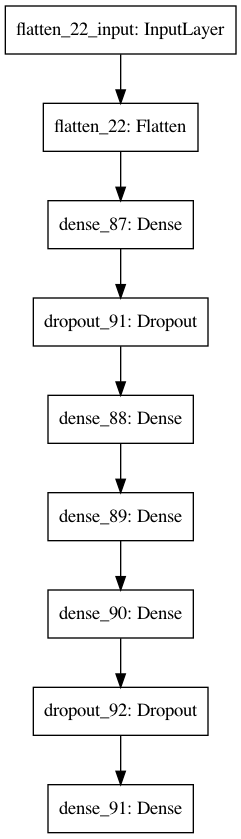

In [135]:
#image [256x256] optimize the deeper net with dropout to prevent overfitting
#conclusion: deeper net did not help AT ALL. stayed at 20% accuracy

# improvement: resized to [100x100] to shorten the run time
# result: statyed at 20% accuracy
model2 = Sequential([Flatten(input_shape=(100,100,3)),
                     Dense(1024, input_shape=(30000,), activation='relu'),
                     Dropout(0.2),
                     Dense(512, input_shape=(1024,), activation='relu'),
                     Dense(256, input_shape=(512,), activation='relu'),
                     Dense(100, input_shape=(256,), activation='relu'),
                     Dropout(0.5),
                     Dense(5, activation='softmax')])
model2.summary()
plot_model(model2, to_file='doc/img/model2.png')

In [136]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=path,histogram_freq=1)

In [137]:
history2 = model2.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 20,
                     verbose = 2,
                     callbacks = [tensorboard_callback])

Epoch 1/20
205/205 - 116s - loss: 2.3135 - accuracy: 0.2295 - val_loss: 1.6054 - val_accuracy: 0.2320
Epoch 2/20
205/205 - 67s - loss: 1.6049 - accuracy: 0.2324 - val_loss: 1.6034 - val_accuracy: 0.2320
Epoch 3/20
205/205 - 64s - loss: 1.6031 - accuracy: 0.2319 - val_loss: 1.6027 - val_accuracy: 0.2320
Epoch 4/20
205/205 - 64s - loss: 1.6029 - accuracy: 0.2324 - val_loss: 1.6024 - val_accuracy: 0.2320
Epoch 5/20
205/205 - 64s - loss: 1.6026 - accuracy: 0.2319 - val_loss: 1.6024 - val_accuracy: 0.2320
Epoch 6/20
205/205 - 64s - loss: 1.6025 - accuracy: 0.2319 - val_loss: 1.6023 - val_accuracy: 0.2320
Epoch 7/20
205/205 - 64s - loss: 1.6025 - accuracy: 0.2319 - val_loss: 1.6023 - val_accuracy: 0.2320
Epoch 8/20
205/205 - 63s - loss: 1.6025 - accuracy: 0.2319 - val_loss: 1.6023 - val_accuracy: 0.2320
Epoch 9/20
205/205 - 63s - loss: 1.6025 - accuracy: 0.2319 - val_loss: 1.6023 - val_accuracy: 0.2320
Epoch 10/20
205/205 - 63s - loss: 1.6025 - accuracy: 0.2319 - val_loss: 1.6023 - val_accur

# TASK 4: Optimizer
Decide the Learning Rate, Optimizer, Loss Function and Metrics to be used and justify why they were chosen. 

# Model 2 MLP with dropout, learning rate decay and sgd
# Result: absolutely no luck. 
# Conclusion: MLP can not solve this problem at all

In [215]:
# improve model 2
# learning rate 0.01 with decay is efficient and tends to be accurate. Will run a few different learning rate to compare
# Optimizer stocastic gradient descent, fast
# loss function, categorical_crossentropy, because we have more than 2 categories of data
# Metrics accuracy, because the number of items in each class are balanced.

model2 = Sequential([Flatten(input_shape=(100,100,3)),
                     Dense(1024, input_shape=(30000,), activation='relu'),
                     Dropout(0.2),
                     Dense(512, input_shape=(1024,), activation='relu'),
                     Dense(256, input_shape=(512,), activation='relu'),
                     Dense(100, input_shape=(256,), activation='relu'),
                     Dropout(0.5),
                     Dense(5, activation='softmax')])
model2.summary()
plot_model(model2, to_file='doc/img/model2.png')

lrate = 0.01
batch_size = 32
decay_rate = lrate/epochs
sgd = optimizers.SGD(lr=lrate, momentum=0.9, decay=decay_rate,nesterov=False)
model2.compile(loss='categorical_crossentropy', 
               optimizer=sgd, 
               metrics=['accuracy'])
path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=path,histogram_freq=1)

history2 = model2.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 20,
                     verbose = 2,
                     callbacks = [tensorboard_callback])

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_102 (Dense)            (None, 1024)              30721024  
_________________________________________________________________
dropout_97 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_103 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_104 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_105 (Dense)            (None, 100)               25700     
_________________________________________________________________
dropout_98 (Dropout)         (None, 100)             

# TASK 5: Training the model
Fit the model to the data by dividing the train data into train and validation set in a ratio of 80:20. Decide the number of epochs and ensure overfitting doesn’t occur.


# TASK 6: Tensorboard
Use Tensorboard to display the accuracy and loss graphs of the training. 


# TASK 7: Building a Convolutional Neural Network
Build a Convolutional Neural Network (CNN) on the given dataset. Decide the number of convolution, pooling layers. Print a summary and architecture of the model. Explain the architecture. Perform all the steps applied on MLP and compare the performances of both. 


# Model 3 CNN
# Result: when image size is 256x256, the model still stuck at 20% accuracy



In [86]:
#weird, why CNN reaches the same exact accuracy 20%??? image size [256x256]

def create_model3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=max_norm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=max_norm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    return model

In [87]:
model3 = create_model3()
model3.summary()
plot_model(model3, to_file='doc/img/model3.png')
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
dropout_24 (Dropout)         (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)    

In [88]:
path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=path,histogram_freq=1)

In [89]:
history3 = model3.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 20,
                     verbose = 2,
                     callbacks = [tensorboard_callback])

Epoch 1/20
205/205 - 3551s - loss: 1.7161 - accuracy: 0.2240 - val_loss: 1.6028 - val_accuracy: 0.2320
Epoch 2/20
205/205 - 4311s - loss: 1.6032 - accuracy: 0.2313 - val_loss: 1.6025 - val_accuracy: 0.2320
Epoch 3/20
205/205 - 3582s - loss: 1.6032 - accuracy: 0.2319 - val_loss: 1.6027 - val_accuracy: 0.2320
Epoch 4/20


KeyboardInterrupt: 

# Model 4, Resized the images to 100x100 to shorten the run time. 
# Result: The results are much better, reaching 69%

In [94]:
#try a quick model4, resized the images to 100x100 to shorten the running time. 
# conclusion: The results are much better, reching 69%
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu', padding='same'))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model4.add(MaxPooling2D())
model4.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model4.add(MaxPooling2D())
model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(512, activation='relu', kernel_constraint=max_norm(3)))
model4.add(Dropout(0.2))
model4.add(Dense(256, activation='relu', kernel_constraint=max_norm(3)))
model4.add(Dropout(0.2))
model4.add(Dense(5, activation='softmax'))

In [95]:
model4.summary()
plot_model(model4, to_file='doc/img/model4.png')
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
dropout_36 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
dropout_37 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 50, 64)      

In [96]:
history4 = model4.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 20,
                     verbose = 2)

Epoch 1/20
205/205 - 348s - loss: 1.5152 - accuracy: 0.3249 - val_loss: 1.2292 - val_accuracy: 0.4982
Epoch 2/20
205/205 - 406s - loss: 1.2809 - accuracy: 0.4622 - val_loss: 1.1707 - val_accuracy: 0.4994
Epoch 3/20
205/205 - 344s - loss: 1.2006 - accuracy: 0.5047 - val_loss: 1.0599 - val_accuracy: 0.5720
Epoch 4/20
205/205 - 369s - loss: 1.1691 - accuracy: 0.5174 - val_loss: 1.0710 - val_accuracy: 0.5531
Epoch 5/20
205/205 - 345s - loss: 1.1171 - accuracy: 0.5363 - val_loss: 1.1627 - val_accuracy: 0.5140
Epoch 6/20
205/205 - 357s - loss: 1.0744 - accuracy: 0.5660 - val_loss: 0.9623 - val_accuracy: 0.5971
Epoch 7/20
205/205 - 319s - loss: 1.0474 - accuracy: 0.5790 - val_loss: 0.9740 - val_accuracy: 0.6178
Epoch 8/20
205/205 - 308s - loss: 1.0122 - accuracy: 0.5927 - val_loss: 0.9409 - val_accuracy: 0.6245
Epoch 9/20
205/205 - 316s - loss: 1.0135 - accuracy: 0.5936 - val_loss: 0.8779 - val_accuracy: 0.6673
Epoch 10/20
205/205 - 311s - loss: 0.9956 - accuracy: 0.5976 - val_loss: 0.8596 - 

In [97]:
model4.save('results/model4.h5')

# Model 5, double the epochs on model4
# Result: reaching 77% accuracy in the validation data, improved upon 69% in model 4

In [99]:
# try the same model with more epoches and tensorboard, 
# performance improved from 65.77% to 77.09% in the training data, 
# and 69.35% to 77.90% in the validation data

model5 = Sequential()
model5.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu', padding='same'))
model5.add(Dropout(0.2))
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model5.add(Dropout(0.2))
model5.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D())
model5.add(Flatten())
model5.add(Dropout(0.2))
model5.add(Dense(512, activation='relu', kernel_constraint=max_norm(3)))
model5.add(Dropout(0.2))
model5.add(Dense(256, activation='relu', kernel_constraint=max_norm(3)))
model5.add(Dropout(0.2))
model5.add(Dense(5, activation='softmax'))

model5.summary()
plot_model(model5, to_file='doc/img/model5.png')
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=path,histogram_freq=1)

history5 = model5.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 50,
                     verbose = 2,
                     callbacks = [tensorboard_callback])

model5.save('results/model5.h5')

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
dropout_46 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
dropout_47 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 50, 50, 64)      

In [228]:
#load from saved model
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu', padding='same'))
model5.add(Dropout(0.2))
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model5.add(Dropout(0.2))
model5.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D())
model5.add(Flatten())
model5.add(Dropout(0.2))
model5.add(Dense(512, activation='relu', kernel_constraint=max_norm(3)))
model5.add(Dropout(0.2))
model5.add(Dense(256, activation='relu', kernel_constraint=max_norm(3)))
model5.add(Dropout(0.2))
model5.add(Dense(5, activation='softmax'))

model5.load_weights("results/model5.h5")
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
preds5 = model5.predict(test_generator)

In [ ]:
#looks like the prediction has quite a few mistakes unfortunately, but get around 70% correct, same as the accuracy rate
prediction_showcase(preds5)

In [255]:
#but the prediction was only 10%. must be the sequence being wrong
#after fixing the order got 76% accuracy!
prediction_to_csv(preds5, generator_test_matched, categories, 'prediction5')

# TASK 8: Optimization Techniques
Apply a minimum of two different optimization techniques on both models (CNN and MLP) e.g. including Dropouts in-between, and list down any performance improvements.


# Model 6, model 5 with sgd and learning rate decay, learning rate starts at 0.02
# Result: bad, accuracy stayed only 20%. learning rate too high

In [129]:
#try the same model with sgd and learning rate decay
# not working! same as previous. Local minimum????
model6 = Sequential()
model6.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu', padding='same'))
model6.add(Dropout(0.2))
model6.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model6.add(MaxPooling2D())
model6.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model6.add(Dropout(0.2))
model6.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model6.add(MaxPooling2D())
model6.add(Flatten())
model6.add(Dropout(0.2))
model6.add(Dense(512, activation='relu', kernel_constraint=max_norm(3)))
model6.add(Dropout(0.2))
model6.add(Dense(256, activation='relu', kernel_constraint=max_norm(3)))
model6.add(Dropout(0.2))
model6.add(Dense(5, activation='softmax'))

model6.summary()
plot_model(model6, to_file='doc/img/model6.png')

epochs = 50
lrate = 0.02
decay = lrate/epochs
sgd = optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model6.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=path,histogram_freq=1)

history6 = model6.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 50,
                     verbose = 2,
                     callbacks = [tensorboard_callback])

model6.save('results/model6.h5')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
dropout_66 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
dropout_67 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 50, 50, 64)      

KeyboardInterrupt: 

# Model 7, model 5 with sgd and learning rate decay, learning rate starts at 0.01
# Result: better! reaching 80% accuracy in the validation data after 50 epochs
# test results 81%, improved!

In [133]:
# try the same model, optimizer with sgd and learning rate decay
# learning rate 0.02 50 epochs. 
# not working! same as previous. Local minimum????
# changed learning rate to 0.05. still no luck
# changed the learning rate to 0.01. the final result reached 80%!
model7 = Sequential()
model7.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu', padding='same'))
model7.add(Dropout(0.2))
model7.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model7.add(MaxPooling2D())
model7.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model7.add(Dropout(0.2))
model7.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model7.add(MaxPooling2D())
model7.add(Flatten())
model7.add(Dropout(0.2))
model7.add(Dense(512, activation='relu', kernel_constraint=max_norm(3)))
model7.add(Dropout(0.2))
model7.add(Dense(256, activation='relu', kernel_constraint=max_norm(3)))
model7.add(Dropout(0.2))
model7.add(Dense(5, activation='softmax'))

model7.summary()
plot_model(model7, to_file='doc/img/model7.png')

epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model7.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=path,histogram_freq=1)

history7 = model7.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 50,
                     verbose = 2,
                     callbacks = [tensorboard_callback])

model7.save('results/model7.h5')

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
dropout_86 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
dropout_87 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 50, 50, 64)      

# TASK 9: Predict
Use the model that is performing better to predict over new_test_data. 
Please pay attention to the class labels, since your predictions will be evaluated against the same labels.

In [188]:
preds7 = model7.predict(test_generator)

In [ ]:
# 81.43% accuracy!
prediction_showcase(preds7)


In [256]:
prediction_to_csv(preds7, generator_test_matched, categories, 'prediction7')

# Model 8, try transfer learning!
use a VGG-19 model which was pre-trained on the ImageNet dataset by fine-tuning it on the Fashion-MNIST dataset.
# Result: validation accuracy 91.27%! test result 90.21%

In [266]:
from keras.applications import vgg19
from keras.callbacks import EarlyStopping

In [262]:
# define input shape
INPUT_SHAPE = (100, 100, 3)

# get the VGG19 model
vgg_layers = vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

vgg_layers.summary()

80142336/80134624 [==============================] - 138s 2us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
____________________________________________________________

In [263]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8de035c650> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f930b151790> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8de1f914d0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8de1987d10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9286239110> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f92f07009d0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8de0645d10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8de17075d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f930b27d510> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8de728ff50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8de74121d0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8de023c

In [268]:
model8 = Sequential()

# Add the vgg convolutional base model
model8.add(vgg_layers)

# add flatten layer
model8.add(Flatten())

# add dense layers with some dropout
model8.add(Dense(256, activation='relu'))
model8.add(Dropout(rate=0.3))
model8.add(Dense(256, activation='relu'))
model8.add(Dropout(rate=0.3))

# add output layer
model8.add(Dense(5, activation='softmax'))

# compile model
model8.compile(optimizer=optimizers.Adam(learning_rate=2e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model8.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_28 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_113 (Dense)            (None, 256)               1179904   
_________________________________________________________________
dropout_106 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_107 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 5)               

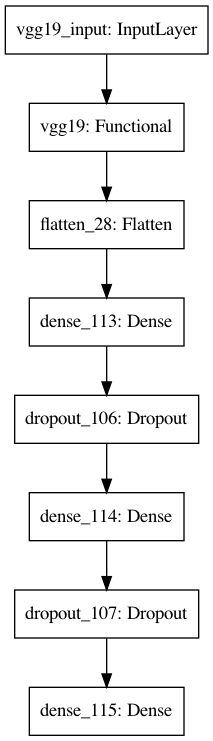

In [269]:
plot_model(model8, to_file='doc/img/model8.png')

In [270]:

path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=path,histogram_freq=1)

es_callback = EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history8 = model8.fit(train_generator, 
                     validation_data = val_generator, 
                     epochs = 100,
                     verbose = 2,
                     callbacks = [tensorboard_callback,es_callback])

Epoch 1/100
205/205 - 2585s - loss: 1.1532 - accuracy: 0.5151 - val_loss: 0.8281 - val_accuracy: 0.6886
Epoch 2/100
205/205 - 2350s - loss: 0.6596 - accuracy: 0.7565 - val_loss: 0.4107 - val_accuracy: 0.8468
Epoch 3/100
205/205 - 2434s - loss: 0.4918 - accuracy: 0.8240 - val_loss: 0.4962 - val_accuracy: 0.8400
Epoch 4/100
205/205 - 1869s - loss: 0.3995 - accuracy: 0.8585 - val_loss: 0.3696 - val_accuracy: 0.8748
Epoch 5/100
205/205 - 1979s - loss: 0.3551 - accuracy: 0.8766 - val_loss: 0.3800 - val_accuracy: 0.8864
Epoch 6/100
205/205 - 1895s - loss: 0.3190 - accuracy: 0.8872 - val_loss: 0.3456 - val_accuracy: 0.8871
Epoch 7/100
205/205 - 1699s - loss: 0.2876 - accuracy: 0.8978 - val_loss: 0.3455 - val_accuracy: 0.8919
Epoch 8/100
205/205 - 1693s - loss: 0.2502 - accuracy: 0.9117 - val_loss: 0.2717 - val_accuracy: 0.9109
Epoch 9/100
205/205 - 1713s - loss: 0.2444 - accuracy: 0.9122 - val_loss: 0.3358 - val_accuracy: 0.8926
Epoch 10/100
Restoring model weights from the end of the best ep

In [271]:
model8.save('results/model8.h5')

In [272]:
prediction8 = model8.predict(test_generator)

In [ ]:
prediction_showcase(prediction8)

In [281]:
prediction_to_csv(prediction8, generator_test_matched, categories, 'prediction8')

# show tensorboard

In [ ]:
%tensorboard --logdir logs/fit